<a href="https://colab.research.google.com/github/meli20002/Industrial-Sound-Anomaly-Detection-using-Transformers/blob/main/fine_tuning_ast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#getting the pump dataset
from google.colab import drive
drive.mount('/content/drive')


!unzip "/content/drive/MyDrive/pump.zip" -d "/content/pump"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/pump.zip
   creating: /content/pump/pump/test/
   creating: /content/pump/pump/test/anomalous/
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0000.wav  
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0001.wav  
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0002.wav  
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0003.wav  
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0004.wav  
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0005.wav  
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0006.wav  
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0007.wav  
  inflating: /content/pump/pump/test/anomalous/section_00_source_test_anomaly_0008.wav  
  inflating: /content/pump/pump/test/anomalou

In [ ]:
import torch
import torchaudio
import random
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.notebook import tqdm
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from torchaudio.transforms import Resample, PitchShift

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

MODEL_CHECKPOINT = "MIT/ast-finetuned-audioset-10-10-0.4593"
SAMPLE_RATE = 16000
MAX_DURATION = 10.0
BATCH_SIZE = 8
MAX_SAMPLES = 2000

Using device: cpu


In [ ]:
#  Data Loading
import random
from pathlib import Path

# Config
data_path = Path("/content/pump/pump")

# 1. Collect Files
# We combine train/normal and test/normal into one big pool of Normal data
all_normal = list((data_path/"train"/"normal").glob("*.wav")) + \
             list((data_path/"test"/"normal").glob("*.wav"))

# Gather all anomalies
all_anomal = list((data_path/"test"/"anomalous").glob("*.wav"))

print(f"Total Normal Files: {len(all_normal)}")
print(f"Total Anomaly Files: {len(all_anomal)}")

# 2. Shuffle and Split (80% Train, 20% Val)
# Set seed for reproducibility
random.seed(42)
random.shuffle(all_normal)
random.shuffle(all_anomal)

n_split = int(0.8 * len(all_normal))
a_split = int(0.8 * len(all_anomal))

# Construct final FILE lists
train_files = all_normal[:n_split] + all_anomal[:a_split]
val_files   = all_normal[n_split:] + all_anomal[a_split:]

# Construct final LABEL lists (0=Normal, 1=Anomaly)
# This order MUST match the file lists exactly!
train_labels = [0] * n_split + [1] * a_split
val_labels   = [0] * (len(all_normal) - n_split) + [1] * (len(all_anomal) - a_split)

# Zip and Shuffle Train (so batches are mixed)
train_combined = list(zip(train_files, train_labels))
random.shuffle(train_combined)
train_files, train_labels = zip(*train_combined)

# Zip and Shuffle Val
val_combined = list(zip(val_files, val_labels))
random.shuffle(val_combined)
val_files, val_labels = zip(*val_combined)

print(f"Final Training Set: {len(train_files)} files")
print(f"Final Validation Set: {len(val_files)} files")

Total Normal Files: 3600
Total Anomaly Files: 600
Final Training Set: 3360 files
Final Validation Set: 840 files


In [ ]:
# Cell 4: Pre-process data into RAM (With Augmentation)
import numpy as np
import random

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

def augment_audio(y, sr):
    """
    Applies random augmentations to the raw audio waveform.
    Fast numpy operations only (No slow pitch shifting).
    """
    # 1. Add Gaussian White Noise (Simulate factory background noise)
    if random.random() < 0.5:
        noise_amp = 0.005 * np.max(y)
        noise = np.random.randn(len(y)) * noise_amp
        y = y + noise

    # 2. Random Gain/Volume (Simulate distance from microphone)
    if random.random() < 0.5:
        gain = random.uniform(0.8, 1.2)
        y = y * gain

    # 3. Time Shift (Roll audio left/right)
    if random.random() < 0.5:
        shift_amt = int(sr * random.uniform(-0.1, 0.1)) # +/- 100ms
        y = np.roll(y, shift_amt)

    return y

def preprocess_set(paths, labels, augment=False):
    input_list = []
    label_list = []

    print(f"Processing {len(paths)} files... (Augmentation={'ON' if augment else 'OFF'})")

    for i, path in enumerate(paths):
        path_str = str(path)

        try:
            # 1. Load Audio (Crop to 4s)
            audio, _ = librosa.load(path_str, sr=SAMPLE_RATE, duration=MAX_DURATION)

            # 2. Apply Augmentation (ONLY if enabled)
            if augment:
                audio = augment_audio(audio, SAMPLE_RATE)

            # 3. Pad/Crop to exact length
            target_len = int(SAMPLE_RATE * MAX_DURATION)
            if len(audio) < target_len:
                audio = np.pad(audio, (0, target_len - len(audio)))
            else:
                audio = audio[:target_len]

            # 4. Extract Spectrogram Features
            inputs = feature_extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt")

            input_list.append(inputs["input_values"].squeeze(0))
            label_list.append(labels[i])

        except Exception as e:
            print(f"Error loading {path_str}: {e}")

        if i % 100 == 0 and i > 0: print(f"Processed {i}...")

    return input_list, label_list


# 1. Process Training Data WITH Augmentation
print("--- Processing TRAINING Data (with Noise/Gain Augmentation) ---")
train_X, train_y = preprocess_set(train_files, train_labels, augment=True)

# 2. Process Validation Data WITHOUT Augmentation
print("\n--- Processing VALIDATION Data (Clean) ---")
test_X, test_y = preprocess_set(val_files, val_labels, augment=False)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

--- Processing TRAINING Data (with Noise/Gain Augmentation) ---
Processing 3360 files... (Augmentation=ON)
Processed 100...
Processed 200...
Processed 300...
Processed 400...
Processed 500...
Processed 600...
Processed 700...
Processed 800...
Processed 900...
Processed 1000...
Processed 1100...
Processed 1200...
Processed 1300...
Processed 1400...
Processed 1500...
Processed 1600...
Processed 1700...
Processed 1800...
Processed 1900...
Processed 2000...
Processed 2100...
Processed 2200...
Processed 2300...
Processed 2400...
Processed 2500...
Processed 2600...
Processed 2700...
Processed 2800...
Processed 2900...
Processed 3000...
Processed 3100...
Processed 3200...
Processed 3300...

--- Processing VALIDATION Data (Clean) ---
Processing 840 files... (Augmentation=OFF)
Processed 100...
Processed 200...
Processed 300...
Processed 400...
Processed 500...
Processed 600...
Processed 700...
Processed 800...


Visualizing Training Sample #0 (Augmented):


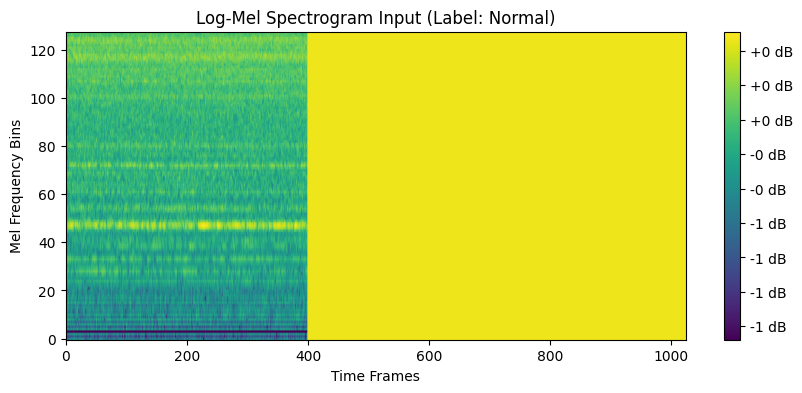

Visualizing Validation Sample #0 (Clean):


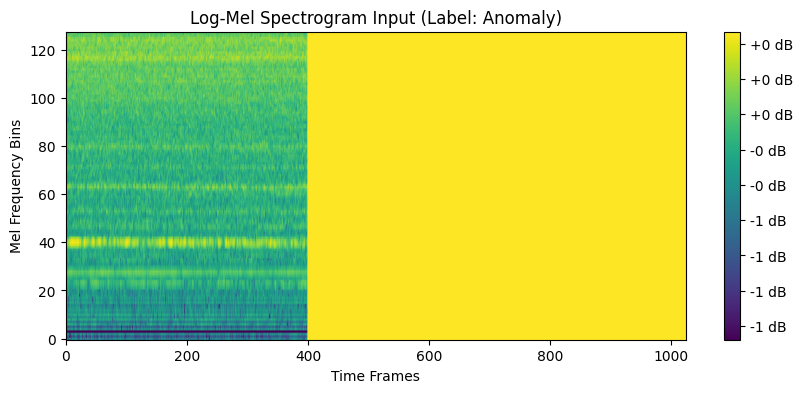

In [ ]:
#Verify and Visualize Log-Mel Spectrograms
import matplotlib.pyplot as plt

def plot_log_mel(tensor_data, label_id):

    spectrogram = tensor_data.T.numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Log-Mel Spectrogram Input (Label: {'Anomaly' if label_id==1 else 'Normal'})")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Visualize a few samples from our processed lists
print("Visualizing Training Sample #0 (Augmented):")
plot_log_mel(train_X[0], train_y[0])

print("Visualizing Validation Sample #0 (Clean):")
plot_log_mel(test_X[0], test_y[0])

In [ ]:
#checking  the shape of the samples
print(train_X[0].shape)
print(test_X[0].shape)

torch.Size([1024, 128])
torch.Size([1024, 128])


In [ ]:
#Create Fast Dataset Object
class FastASTDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Trainer expects dictionary with 'input_values' and 'labels'
        return {
            "input_values": self.features[idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create objects using the data from Cell 4
train_dataset = FastASTDataset(train_X, train_y)
test_dataset = FastASTDataset(test_X, test_y)


In [ ]:
# Load Model & Freeze Body
model = AutoModelForAudioClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2,                     # Binary Classification (Normal vs Anomaly)
    ignore_mismatched_sizes=True      # Essential: Drops the old AudioSet classification head
)

# Map labels for readability in the UI later
model.config.id2label = {0: "NORMAL", 1: "ANOMALY"}
model.config.label2id = {"NORMAL": 0, "ANOMALY": 1}

#  FREEZE THE TRANSFORME
print("Freezing transformer layers to speed up training...")
for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

# Unfreeze only the classifier
for param in model.classifier.parameters():
    param.requires_grad = True



config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Freezing transformer layers to speed up training...
✅ Model loaded. Body is FROZEN. Only the head will train.


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00


In [ ]:

import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

# Load the metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Configuration
training_args = TrainingArguments(
    output_dir="./ast_turbo_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)



In [ ]:
from transformers import TrainerCallback
from tqdm.auto import tqdm

class TqdmCallback(TrainerCallback):
    def __init__(self):
        self.pbar = None

    def on_train_begin(self, args, state, control, **kwargs):
        total_steps = state.max_steps if state.max_steps != 0 else (
            len(kwargs["train_dataloader"]) * args.num_train_epochs
        )
        self.pbar = tqdm(
            total=total_steps,
            desc="Training",
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} | {elapsed}<{remaining}",
            colour="cyan",
            leave=True
        )

    def on_step_end(self, args, state, control, **kwargs):
        if self.pbar is not None:
            # Update progress
            self.pbar.update(1)

            # Show latest metrics
            if state.log_history:
                last_log = state.log_history[-1]
                loss = last_log.get("loss", None)
                lr = last_log.get("learning_rate", None)
                epoch = last_log.get("epoch", state.epoch)

                postfix = {}
                if loss is not None:
                    postfix["loss"] = f"{loss:.4f}"
                if lr is not None:
                    postfix["lr"] = f"{lr:.2e}"
                postfix["epoch"] = f"{epoch:.2f}"

                self.pbar.set_postfix(postfix)

    def on_epoch_end(self, args, state, control, **kwargs):
        if "eval_accuracy" in state.log_history[-1]:
            acc = state.log_history[-1]["eval_accuracy"]
            self.pbar.set_postfix({"eval_acc": f"{acc:.4f}", "best": "✓" if acc == state.best_metric else ""})

    def on_train_end(self, args, state, control, **kwargs):
        if self.pbar:
            self.pbar.close()
        print(f"\nTraining finished! Best eval accuracy: {state.best_metric:.4f}")

# Add it to your existing trainer
trainer.add_callback(TqdmCallback())

In [ ]:

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/324 | 00:00<?